In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_accuracies(accuracies):
    """
    Expects a pandas datafame with colums containing column lengths and indices containing doc depths
    """
    fig, ax = plt.subplots(figsize=(15, 10))

    # colors copied from reference plot
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    sns.heatmap(
        100 * accuracies, # convert to percent
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=100,
        xticklabels=[str(int(length / 1000)) + 'k' for length in data.columns],
        yticklabels=[str(percent) + '%' for percent in data.index],
        linecolor='gray',
        linewidths=0.1
    )

    ax.set_title('Pressure Testing StreamingLLM + RAG', pad=20, size=16)
    ax.set_xlabel('Context Length (# tokens)', size=14)
    ax.set_ylabel('Document Depth', size=14)

    fig.tight_layout()
    return fig

In [117]:
import os
import re

# Results directory + path stuff

RESULTS_FILENAME_PATTERN = r'(\d+)\D+(\d+)' # pull out two integers for length & percent

def result_filename(length, percent):
    "integer length and integer 0 <= percent <= 100"
    return f'prompt_context_length_{length}_depth_percent{percent}.txt'

def result_path(results_dir, length, percent):
    return os.path.join(results_dir, result_filename(length, percent))

def all_result_filenames(results_dir):
    return [
        file for file in os.listdir(results_dir)
        if re.search(RESULTS_FILENAME_PATTERN, file) # ignore .ipynb_checkpoints stuff in there
    ]

def all_result_paths(results_dir):
    return [os.path.join(results_dir, file) for file in all_results_filename(results_dir)]

def result_params(result_filename):
    matches = re.search(RESULTS_FILENAME_PATTERN, result_filename)
    if matches:
        (length, percent) = matches.groups()
        return (int(length), int(percent))


# results file testing

class ParsedResult:
    def __init__(self, result_text):
        self.result_text = result_text
        self.parse()

    def _dummy_passes(self):
        """
        more or less a dummy implementation that checks for Dolores Park
        in about the most naive way possible
        """
        lower = self.parsed_result.lower()
        return 'sandwich' in lower and 'dolores park' in lower

    def accuracy(self):
        """return real 0 <= accuracy <= 1"""
        return float(self._dummy_passes())
        
    def parse(self):
        """
        dummy implementation: just retrieves final assistant prompt
        """
        self.parsed_result = self.result_text.split('ASSISTANT:')[-1].strip()


def result_accuracy(result_path):
    with open(result_path, 'r') as f:
        result_text = f.read()
    parsed_result = ParsedResult(result_text)
    return parsed_result.accuracy()

In [122]:
def construct_df(results_dir):
    return pd.DataFrame(
        [
            (
                *result_params(result_file),
                result_accuracy(os.path.join(results_dir, result_file))
            )
            for result_file in all_result_filenames(results_dir)
        ],
        columns=['length','percent','accuracy']
    )

def results_for_plot(results_dir):
    """
    construct a dataframe, pivot it to prepare for plotting
    """
    df = construct_df(results_dir)
    return df.pivot(index='percent', columns='length', values='accuracy').sort_index(ascending=False)

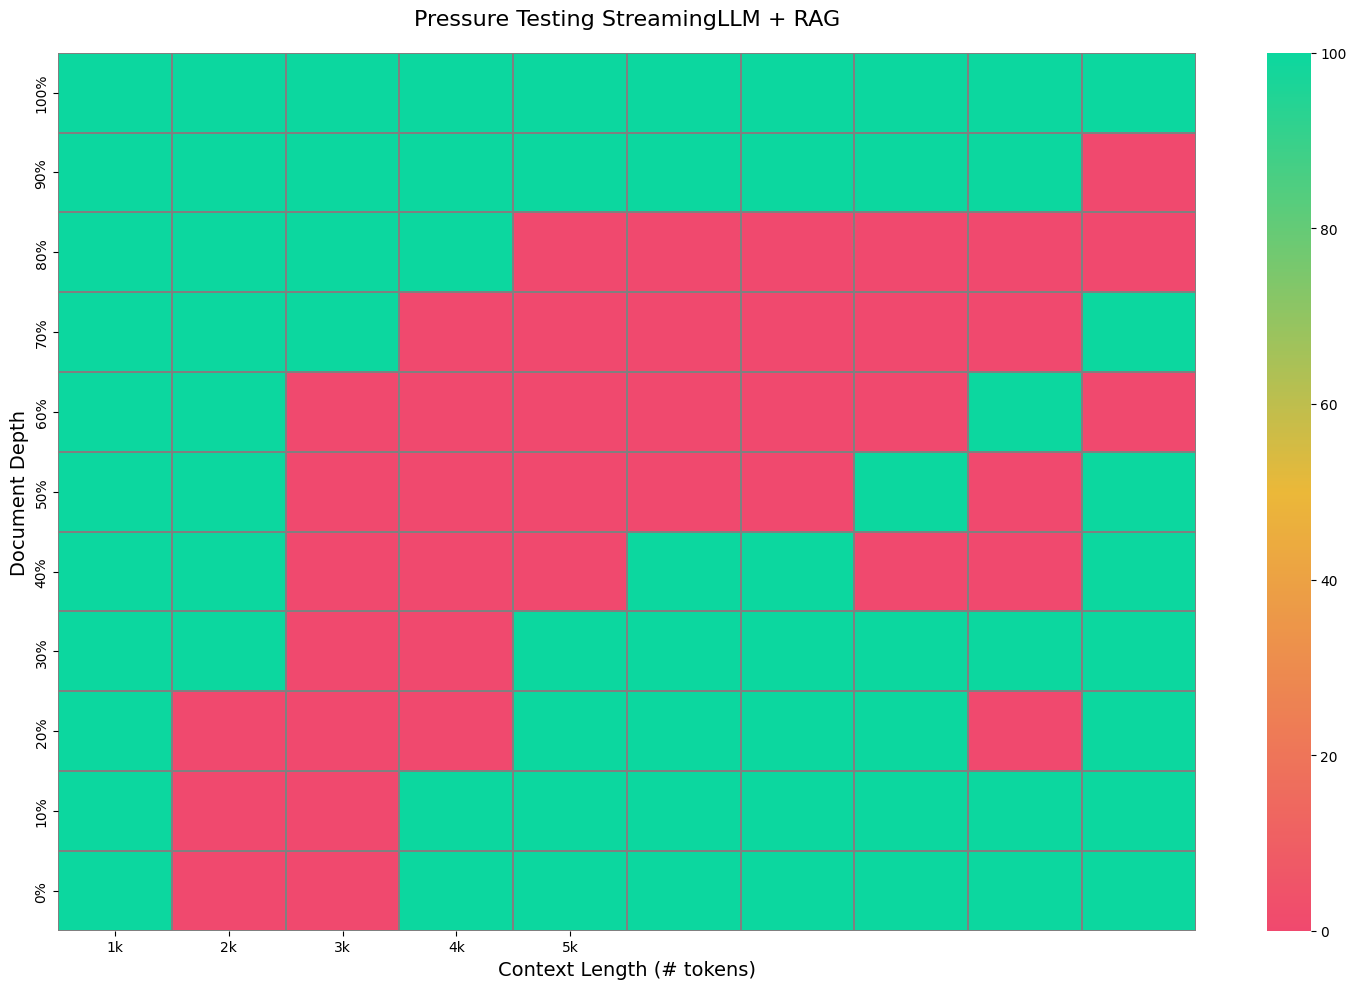

In [135]:
RESULTS_DIR = os.path.join(os.pardir, 'results', 'llama2_chunk_100_size_4096_w_retriever')
fig = plot_accuracies(results_for_plot(RESULTS_DIR))
fig.savefig('test_accuracies.png', dpi=300, bbox_inches='tight')